In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [2]:
# image = 'hor1DRCs/jdan20010_drc.fits'

In [4]:
# # fits.info(image)

# hdu = fits.open(image)
# sci = hdu[1].data
# hdr = hdu[0].header
# tab = hdu[4].data
# hdu.close()

In [5]:
# temp_sci = sci*hdr['texptime'] + (0.03/0.05)**2*np.sum(tab['mdrizsky'])/2

In [6]:
# fits.writeto('hor1DRCs/F814W_ctsALL_M.fits', temp_sci, header=hdr)

In [7]:
image = 'hor1DRCs/F814W_ctsALL_M.fits'
# fits.info(image)

hdu = fits.open(image)
sci = hdu[0].data
hdr = hdu[0].header
hdu.close()

In [8]:
data = sci.copy()

In [9]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)

110.48591 109.921455 19.541706


In [10]:
daofind = DAOStarFinder(fwhm=2., threshold=5.*std)
sources = daofind(data - median)
print(len(sources))

6557


In [11]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r4 = CircularAperture(positions, r=4.)

rawflux_r4 = aperture_photometry(data, apertures_r4)

In [12]:
rawflux_r4['roundness1']= sources['roundness1']
rawflux_r4['roundness2']= sources['roundness2']
rawflux_r4['sharpness']= sources['sharpness']

In [13]:
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [14]:
rawflux_r4['annulus_median'] = bkg_median
rawflux_r4['aper_bkg'] = bkg_median*apertures_r4.area
rawflux_r4['final_phot'] = rawflux_r4['aperture_sum'] - rawflux_r4['aper_bkg']

In [15]:
apertures_r6 = CircularAperture(positions, r=6.)
rawflux_r6 = aperture_photometry(data, apertures_r6)

rawflux_r6['aper_bkg'] = rawflux_r4['annulus_median']*apertures_r6.area
rawflux_r6['final_phot'] = rawflux_r6['aperture_sum'] - rawflux_r6['aper_bkg']

In [16]:
mask_negative = (rawflux_r4['final_phot'] > 0) & (rawflux_r6['final_phot'] > 0)

rawflux_pos_r4 = rawflux_r4[mask_negative]
rawflux_pos_r6 = rawflux_r6[mask_negative]

mag_r4 = -2.5*np.log10(rawflux_pos_r4['final_phot'])
mag_r6 = -2.5*np.log10(rawflux_pos_r6['final_phot'])

deltamag = mag_r4 - mag_r6

/Users/hr8jz/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


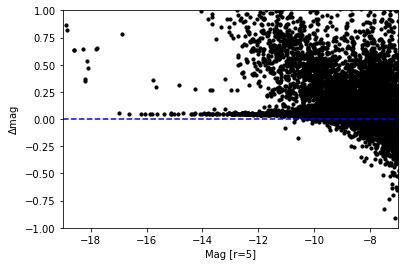

In [17]:
plt.figure()
plt.scatter(mag_r6, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-19,-7)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

plt.show()

0.0494034729166799


Text(0, 0.5, '$\\Delta$mag')

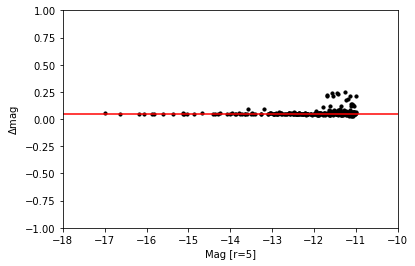

In [18]:
mask = (mag_r6 > -17.) & (mag_r6 < -11.) & (deltamag > 0.) & (deltamag < 0.25)

mean, median, std = sigma_clipped_stats(deltamag[mask], sigma=3.0, maxiters=5)
apcor = median
print(apcor)

plt.figure()
plt.scatter(mag_r6[mask], deltamag[mask], c='k', s=10)
plt.axhline(apcor,ls='-',c='r')
plt.xlim(-18,-10)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

In [20]:
zpt = 26.779

In [21]:
final_phot = -2.5*np.log10(rawflux_pos_r4['final_phot']) - apcor + zpt
print(final_phot[:20])

    final_phot    
------------------
20.353972764592886
18.586720092612467
19.799140301734738
 16.50679143780608
18.492237624015747
16.709519916182007
 18.44681258024256
17.913452138885603
17.538297497326365
18.916625857129294
17.632906130078077
19.292763258380507
17.260061360434726
16.324441838973847
16.831581423643787
20.086074647409358
19.013617689599013
 18.66499760818216
 18.85544073159276
19.242314412578892


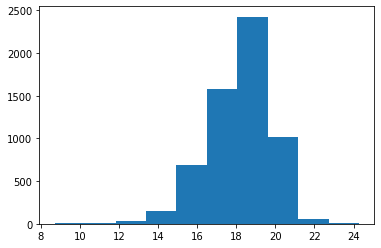

In [22]:
plt.hist(final_phot)
plt.show()